<a href="https://colab.research.google.com/github/nitishw229/VanillaGAN/blob/main/myNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Allow access to GD for data.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/classifierAssignment/

Dataset  Models  myCMatrix.png	myNotebook.ipynb


In [4]:
# Define the project/data path here, will help when running on other machines.
workingPath = '/content/drive/MyDrive/classifierAssignment/'

In [5]:
# Imports

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img, save_img

import numpy as np
import os, glob

In [6]:
# Some more imports.

from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import Flatten
from keras.layers import Dense, MaxPooling2D
from keras.layers import Dropout
from tensorflow.keras import activations
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.optimizers import Adam, RMSprop, SGD
from cv2 import resize
import cv2

In [7]:

# Use This Function To Generate Augmented Images, takes a path of a directory which is expected to have .bmp files, and generates `numAug` augmented images and saves them as 
# either .npy or .bmp in `outputPath`.

def dataAug(augFolder, outputPath, outShape=(288, 360), numAug=11, augImages=None, saveNumpy=False, doReturn=False):

  aug = ImageDataGenerator(
      rotation_range = 10,
      zoom_range = 0.15,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      shear_range = 0.15,
      horizontal_flip = True )

  if os.path.isdir(augFolder):

    folder = [ augFolder + '/' + i for i in os.listdir(augFolder) if i[-4:] == '.bmp']
    if augImages is None: augImages = len(folder)
    fCounter = len(folder)
    if not os.path.exists(outputPath): os.mkdir(outputPath)

    if doReturn: mData = []

    for idx, imgIdx in enumerate(np.random.choice(len(folder), augImages, False)):
      print(' Working on Image {} of {}'.format(idx+1, augImages))
      img = load_img(folder[imgIdx])
      data = img_to_array(img).astype('uint8')

      if outShape is not None: data = resize(data, outShape)
      if saveNumpy: np.save(outputPath + '/' + str(idx) + '.bmp', data)
      else: save_img(outputPath + '/' + str(idx) + '.bmp', data)

      samples = np.expand_dims(data, 0)
      it = aug.flow(samples, batch_size=1)
      for i in range(numAug):
        batch = it.next()
        sImage = batch[0].astype('uint8')
        if outShape is not None: sImage = resize(sImage, outShape)
        if saveNumpy: np.save(outputPath + '/' + str(fCounter) + '.bmp', sImage)
        else: save_img(outputPath + '/' + str(fCounter) + '.bmp', sImage)

        if doReturn: mData.append(sImage)
        fCounter += 1
        pass
    if doReturn: return mData

# Simple function to help resize a bunch of images/arrays.

def resizeImages(augFolder, outputPath, outShape=(288, 360), saveNumpy=False):

  if os.path.isdir(augFolder):
    folder = [ augFolder + '/' + i for i in os.listdir(augFolder) if i[-4:] == '.bmp']
    if not os.path.exists(outputPath): os.mkdir(outputPath)

    for idx in range(len(folder)):
      print(' Working on Image {} of {}'.format(idx+1, len(folder)))
      img = load_img(folder[idx])
      data = img_to_array(img).astype('uint8')

      if outShape is not None: data = resize(data, outShape)
      if saveNumpy: np.save(outputPath + '/' + folder[idx].split[-1], data)
      else: save_img(outputPath + '/' + folder[idx].split('/')[-1], data)

# The two functions below were used to play with segmention masks and to see how they can furthur help the cause, details explained at the end of file.

# Used to get individual segmented masks from the image masks, as each of the image masks have multiple segments.

def onGetIndividualSegments(mMask):

    imgray = cv2.cvtColor(mMask, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 2)
    thresh = thresh.astype(np.uint8)

    contours, l1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    newInm = np.zeros(mMask.shape,np.uint8)    
    mSegments = []
    for bb in bounding_boxes:
        newInm = np.zeros(mMask.shape,np.uint8)
        newInm[bb[1]:bb[3] + bb[1],bb[0]:bb[2] + bb[0],:] = mMask[bb[1]:bb[3] + bb[1],bb[0]:bb[2] + bb[0],:]
        newInm[newInm>0] = 1
        mSegments.append(newInm)
    return mSegments

def onSegmentData(dataPath, outputPath, segmentPath, outShape=(150, 150), saveNumpy=False):

    folder = [ dataPath + '/' + i for i in os.listdir(dataPath) if i[-4:] == '.bmp']
    if not os.path.exists(outputPath): os.mkdir(outputPath)

    for idx in range(len(folder)):
        print(' Working on Image {} of {}'.format(idx+1, len(folder)))
        tImg = img_to_array( load_img(folder[idx]) ).astype('uint8')
        fileName = folder[idx].split('/')[-1].split('.')[0]
        tMask = img_to_array( load_img( segmentPath + fileName + '_expert.bmp' ) ).astype('uint8')
        allMasks = onGetIndividualSegments(tMask)

        for midx, mask in enumerate(allMasks):
            try:
                tImg = tImg[576-mask.shape[0]:, 720-mask.shape[1]:, :]
                mask[mask>0] = 1
                w = np.where(mask>0)
                tCell = tImg[ max(0, w[0].min()-50):min(tImg.shape[0], w[0].max()+50), max(0, w[1].min()-50):min(tImg.shape[1], w[1].max()+50), : ]
                tCell = resize(tCell, outShape)

                if saveNumpy: np.save(outputPath + '/' + str(midx) + '_' + str(fileName) + '_seg.bmp', tCell)
                else: save_img(outputPath + '/' + str(midx) + '_' + str(fileName) + '_seg.bmp', tCell)
            except Exception as ex: print('Some Ex 1 : {}'.format(str(ex)))


In [8]:
# for fl in ['Baso', 'eosi', 'lymp', 'mixt', 'mono', 'neut']:
#   print('\nWorking on class {}'.format(fl))
#   onSegmentData( workingPath + 'Dataset/MainDataset/{}'.format(fl), workingPath + 'Dataset/croppedData/{}'.format(fl), workingPath + 'Dataset/GroundTruthSegmentation/{}/areaforexpert1/'.format(fl))


In [9]:

# Augment all available data.

if not os.path.exists(workingPath + 'Dataset/augLarge_2'): os.mkdir(workingPath + 'Dataset/augLarge_2')
# dataX, _dataY = [], []
for idx, fl in enumerate(['Baso', 'eosi', 'lymp', 'mixtAug', 'mono', 'neut']):
    print('\nWorking on class {}'.format(fl))
    prevLen = len(dataX)
    dataAug( workingPath + 'Dataset/MainDataset/{}'.format(fl), workingPath + 'Dataset/augLarge_2/{}'.format(fl) )
    # _dataY += [idx] * (len(dataX)-prevLen)
    # classNames[idx] = fl

# dataX, _dataY = np.asarray(dataX), np.asarray(_dataY, dtype=np.uint8)


Working on class Baso


NameError: ignored

In [ ]:

# Loads all available data (.bmp files) in `dataPath` directory in a single array along with their labels.

def onLoadData(dataPath, useFolders=['Baso', 'eosi', 'lymp', 'mixtAug', 'mono', 'neut'], imageSize=None):

  classNames = {}
  dataX, dataY = [], []

  for idx, folder in enumerate(useFolders):

    print('\n Working on folder {} of {}, {}'.format(idx+1, len(useFolders), folder))
    prevLen = len(dataX)
    for fl in os.listdir(dataPath + '/' + folder)[:600]: 
      if fl[-4:] != '.bmp': continue
      dataX.append( img_to_array( load_img(dataPath+'/'+folder+'/'+fl) ).astype(np.uint8) )

    dataY += [idx] * (len(dataX)-prevLen)
    classNames[idx] = folder
  return np.asarray(dataX), np.asarray(dataY, dtype=np.uint8), classNames


In [ ]:
# Get the data...
dataX, _dataY, classNames = onLoadData(workingPath + 'Dataset/augLarge_2')

In [ ]:
# One hot encode the lables, the normal integer based labeling would ofcource also work with SPARSE_CATEGORICAL_CROSSENTROPY.
dataY = np.zeros((_dataY.size, _dataY.max()+1), dtype=np.uint8)
dataY[np.arange(_dataY.size), _dataY] = 1

In [ ]:
# Normalize the data..
dataX = dataX.astype(np.float32)
dataX = (dataX/255)

In [ ]:
# Randomize the data..
ranIdx = np.random.choice(dataX.shape[0], dataX.shape[0], False)
dataX, dataY = dataX[ranIdx], dataY[ranIdx]

In [ ]:
# Lets save some for testing later..

testX, testY = dataX[-50:], dataY[-50:]
dataX, dataY = dataX[:-50], dataY[:-50]

In [ ]:
# Some logs..
dataX.shape, dataY.shape, classNames, dataX.min(), dataX.max()

In [ ]:
testX.shape, testY.shape, classNames, testX.min(), testX.max()


In [ ]:
# Create the model.

def onCreateModel(inputShape=(360, 288, 3), nLayers=5, outNeurons=6):

    layerInput = Input(shape=inputShape)
    myModel = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(layerInput)

    nFilters = 16
    for i in range(nLayers):
        myModel = Conv2D(filters=nFilters, kernel_size=3, padding='same', activation='relu')(myModel)
        myModel = MaxPooling2D(pool_size=(2, 2))(myModel)
        nFilters *= 2

    myModel = Flatten()(myModel)
    myModel = Dense(1024, activation='relu')(myModel)

    myModel = Dense(outNeurons, activation='softmax')(myModel)
    myModel = Model(layerInput, myModel)
    myModel.summary()

    return myModel


In [1]:
myModel = onCreateModel()

NameError: ignored

In [ ]:
# Get the optimizer and compile the model.

thisOpt = Adam(learning_rate=0.00001)
# thisOpt = SGD(learning_rate=0.0001)
# thisOpt = RMSprop(learning_rate=0.00001)
myModel.compile(loss='categorical_crossentropy', optimizer=thisOpt, metrics=['accuracy'])

In [ ]:
# Start the train.

trainHistory = myModel.fit(dataX[:3000], dataY[:3000], batch_size=32, epochs=200, verbose=2, validation_split=0.1, shuffle=True)

In [ ]:
# Save the model.
if not os.path.exists(workingPath + '/Models'): os.mkdir(workingPath + '/Models')
myModel.save(workingPath + '/Models/M1_VA_0.9_VL_0.86.hdf5')

In [ ]:
preY = myModel.predict(testX)
print('Testing Accuracy', ((preY.argmax(1) == testY.argmax(1)).sum())/testY.shape[0])

Testing Accuracy 0.92


In [ ]:
# # Test on testing data...
# preY = myModel.predict(testX)
# print('Testing Accuracy', ((preY.argmax(1) == testY.argmax(1)).sum())/testY.shape[0])

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plotConfusionMatrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



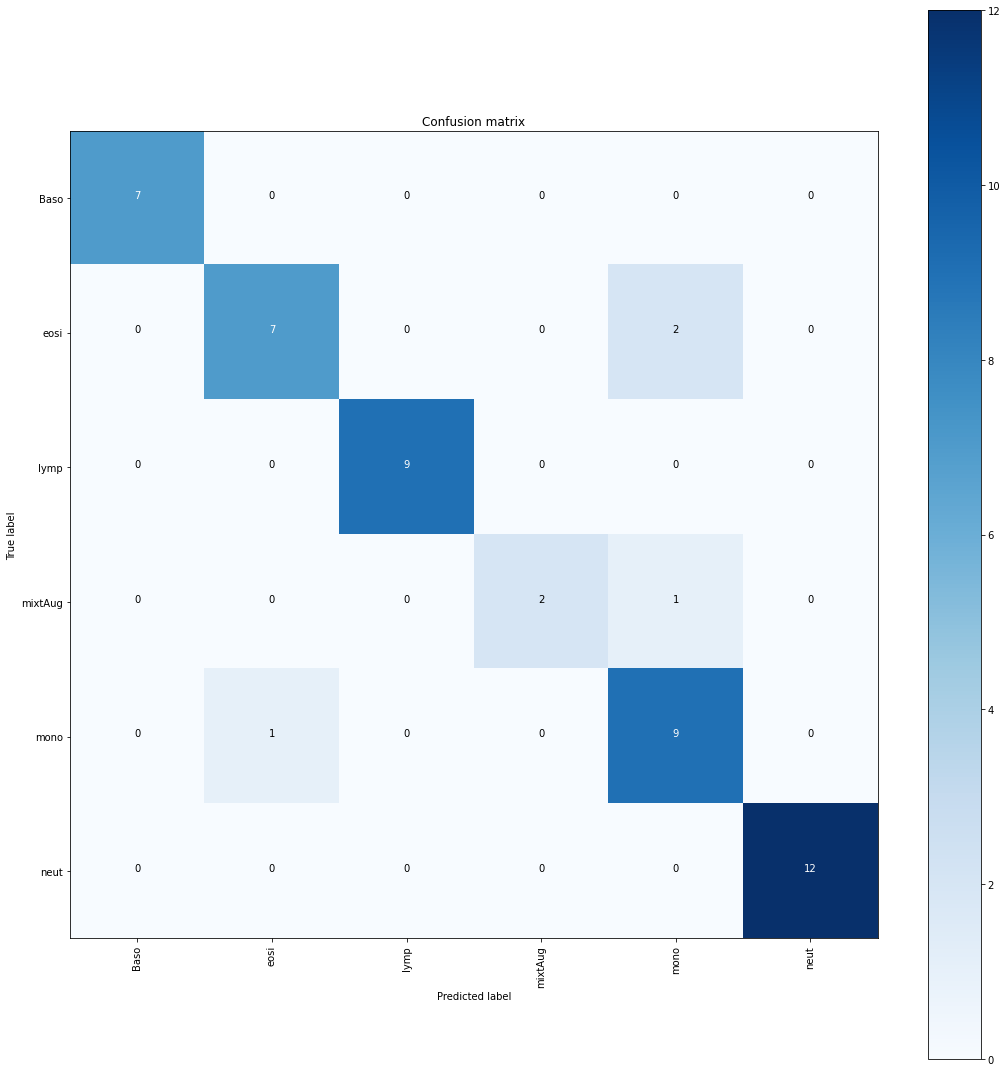

In [ ]:
cM = confusion_matrix(testY.argmax(axis=1), preY.argmax(axis=1))
plotConfusionMatrix(cM, [classNames[i] for i in range(6)])

In [ ]:
"""

Explanation.

The problem is a prime example of imbalanced and low data count. Here is how I steps that I took to end up with the above solution. Initially, I tried to train a model without creating any new data, rather just balancing the classes. The class "mist" was heavily
imbalanced as compared to others. I just augmented this particular class. The model trained on this data failed as expected, as there was not much to learn from.
Next, I tried to play with the segmentation masks to segment out the part of the image responsible for its class. I removed the segmented part, saved it as a (150, 150, 3) sized image, did some augmentatoin and trained a model. The model performed mediocrely. 
The accuracy was arount 67% - 70% over some models that I trained. 
There were several issues with the approach. First, because the data was segmented and it was only a small image coupled with the nature of data, which does not has a lot of unique
"features" or variation in the concerned part of the image, augmentation after segmentation was not very helpful. The augmented data barely differed from the orignal. If augmentation was to be performed before segmentation, all augmentation function needed to 
be performed identically and in the same order on the image as well as its mask which was a seperate task altogether presenting its own complexites, propbably I would have to write all the augmentation operation from scratch to identically augement a pair of images.
Second issue was that now the model was trained on smaller images all images that the model will predict also need to be of the same shape. Which means something like sliding window (which would be slow and probably impracticle) would be required or a YOLO like 
model would be needed, something I did not have time for.
Finally the best approach was to augment the data as is, to a much larger number. I ended up generating around 3.5K samples. I changed the images size to half of the orignal. There were 2 prominant reason for this.
1 - Upon exploring the data, it became clear that image size was way more that adequate for a model. The actual ratio of the image area to the area of concern (the part thhat defines the class was very low). Reducing the size to half or even less will
    not lead to any significant loss of features.
2 - This would speed up the training of the model, while keeping the number of trainable parameters to a minimum, thus reducing complexity for the model and helping avoid overfitting due to a large model.
3 - I wanted to avoid using a Data Generator. The prime reason being that it is very slow especially on Google Drive. I tested the model using a Generator, however the data loding was slower that training of an epoch (on GPU). Saving the data as numpy files
    helped a bit but was still slower. Lowering the image size means low data size to load on RAM and faster access.

Learning rate as usual had a huge affect on training. Increaing the learning that any higher from 0.00001, swiftly deteriorated the learning performance, however different optimizers did not offer much difference.
"""



In [ ]:
# Wanted to try with residual layers, but ran out of time.


def onAddConvBlock(thisInput, convConfig):
    skipLayer = None
    for layIdx in range(len(convConfig['layers'])):
        tConf = convConfig['layers'][layIdx]
        if convConfig['skipFromInput'] and layIdx == 0: skipLayer = thisInput
        if 'padConfig' in tConf.keys(): thisInput = ZeroPadding2D(tConf['padConfig'])(thisInput)
        thisInput = Conv2D(filters=tConf['filters'], kernel_size=tConf['kernels'], strides=tConf['strides'], padding=tConf['padding'])(thisInput)
        thisInput = BatchNormalization()(thisInput)
        thisInput = LeakyReLU(alpha=tConf['leakyAlpha'])(thisInput)
        if not convConfig['skipFromInput'] and convConfig['doSkip'] and layIdx == 0: skipLayer = thisInput
    return add([skipLayer, thisInput]) if convConfig['doSkip'] else thisInput

def onCreateModel_Res(inputShape=(576, 720, 3), outNeurons=5):

  layerInput = Input(shape=inputShape)

  # Prepare Input For Feature Extraction
  myModel = Conv2D(filters=32, kernel_size=3, padding='same')(layerInput)
  myModel = BatchNormalization()(myModel)
  myModel = LeakyReLU(alpha=0.001)(myModel)

  myModel = onAddConvBlock( myModel, {
      'layers':[
                {'filters':64, 'kernels':3, 'strides':1, 'padding':'same', 'leakyAlpha':0.001},
                {'filters':32, 'kernels':1, 'strides':1, 'padding':'same', 'leakyAlpha':0.001},
                {'filters':64, 'kernels':3, 'strides':1, 'padding':'same', 'leakyAlpha':0.001} ],
      'doSkip':True,
      'skipFromInput':False,
  } )

  myModel = onAddConvBlock( myModel, {
      'layers':[
                {'filters':128, 'kernels':3, 'strides':2, 'padding':'valid', 'leakyAlpha':0.001, 'padConfig':((1,0),(1,0))},
                {'filters':64, 'kernels':1, 'strides':1, 'padding':'same', 'leakyAlpha':0.001},
                {'filters':128, 'kernels':3, 'strides':1, 'padding':'same', 'leakyAlpha':0.001} ],
      'doSkip':True,
      'skipFromInput':False,
  } )

  myModel = onAddConvBlock( myModel, {
      'layers':[
                {'filters':256, 'kernels':3, 'strides':2, 'padding':'valid', 'leakyAlpha':0.001, 'padConfig':((1,0),(1,0))},
                {'filters':128, 'kernels':1, 'strides':1, 'padding':'same', 'leakyAlpha':0.001},
                {'filters':256, 'kernels':3, 'strides':1, 'padding':'same', 'leakyAlpha':0.001} ],
      'doSkip':True,
      'skipFromInput':False,
  } )

  myModel = onAddConvBlock( myModel, {
      'layers':[
                {'filters':512, 'kernels':3, 'strides':2, 'padding':'valid', 'leakyAlpha':0.001, 'padConfig':((1,0),(1,0))},
                {'filters':256, 'kernels':1, 'strides':1, 'padding':'same', 'leakyAlpha':0.001},
                {'filters':512, 'kernels':3, 'strides':1, 'padding':'same', 'leakyAlpha':0.001} ],
      'doSkip':True,
      'skipFromInput':False,
  } )

  myModel = onAddConvBlock( myModel, {
      'layers':[
                {'filters':512, 'kernels':3, 'strides':2, 'padding':'valid', 'leakyAlpha':0.001, 'padConfig':((1,0),(1,0))},
                {'filters':256, 'kernels':1, 'strides':1, 'padding':'same', 'leakyAlpha':0.001},
                {'filters':512, 'kernels':3, 'strides':1, 'padding':'same', 'leakyAlpha':0.001} ],
      'doSkip':True,
      'skipFromInput':False,
  } )

  myModel = Flatten()(myModel)
  myModel = Dense(outNeurons)(myModel)

  myModel = Model(layerInput, myModel)
  myModel.summary()

  return myModel


In [ ]:
# onCreateModel()

In [ ]:
# Get the data...
dataX, _dataY, classNames = onLoadData(workingPath + 'Dataset/augLarge_2')

In [ ]:
# One hot encode the lables, the normal integer based labeling would ofcource also work with SPARSE_CATEGORICAL_CROSSENTROPY.
dataY = np.zeros((_dataY.size, _dataY.max()+1), dtype=np.uint8)
dataY[np.arange(_dataY.size), _dataY] = 1

In [ ]:
# Normalize the data..
dataX = dataX.astype(np.float32)
dataX = (dataX/255)

In [ ]:
# Randomize the data..
ranIdx = np.random.choice(dataX.shape[0], dataX.shape[0], False)
dataX, dataY = dataX[ranIdx], dataY[ranIdx]

In [ ]:
predY = myModel.predict(dataX)
print('Testing Accuracy', ((predY.argmax(1) == dataY.argmax(1)).sum())/dataY.shape[0])

In [ ]:
cM = confusion_matrix(dataY.argmax(axis=1), predY.argmax(axis=1))
plotConfusionMatrix(cM, [classNames[i] for i in range(6)])